In [52]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as _sum, avg, count, round
import numpy as np
import pandas as pd
import seaborn as sns
import os
import logging
import matplotlib.pyplot as plt
from scipy.stats import linregress
from matplotlib.cm import get_cmap
import warnings
warnings.filterwarnings('ignore')

# Problem Statement 3: Product Sales Performance Evaluation

**Objective:** Evaluate the sales performance of products to identify top-selling items and assess category performance.

**Description:**
1.	Analyse transactions.csv to determine total revenue and sales volume for each product.
2.	Join with products.csv to categorize products and evaluate performance by product category.

**Expected Deliverables:**
- A detailed analysis of sales performance, identifying top-selling products and categories.
- An assessment of how pricing affects sales volume.


In [53]:
%run utilities/common_utility.ipynb
%run utilities/bar_plot_with_line.ipynb

24/09/09 05:29:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Logs Configuration

In [54]:
log_file_path = 'logs/product_sales_performance_evaluation.log'
logger = initialize_logger(log_file_path)

logger.info("Logger initialized with dynamic path!")

2024-09-09 05:29:48,511 - logger - INFO - Logger initialized with dynamic path!


# Initialized Spark Session and Loaded Data into Spark Dataframe

In [55]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Product Sales Performance Evaluation") \
    .getOrCreate()

# Load data into Spark DataFrames
customers_df = spark.read.csv("Cleaned_data/cleaned_customers.csv", header=True, inferSchema=True)
transactions_df = spark.read.csv("Cleaned_data/cleaned_transactions.csv", header=True, inferSchema=True)
products_df = spark.read.csv("Cleaned_data/cleaned_products.csv", header=True, inferSchema=True)

24/09/09 05:29:48 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Total Revenue and Sales Volume of Each Product

In [56]:
logger.info("Total Revenue and Sales Volume of Each Product")
# Join the transactions DataFrame with the products DataFrame on Product_ID
merged_df = transactions_df.join(products_df, on='Product_ID')

# Calculate total revenue and sales volume for each product
product_sales_df = merged_df.groupBy("Product_ID", "Product_Name", "Category", "Price").agg(
    _sum("Amount").alias("Total_Revenue"),
    count("Transaction_ID").alias("Sales_Volume")
)

# Show the results
product_sales_df.show(5,truncate=False)

2024-09-09 05:29:49,042 - logger - INFO - Total Revenue and Sales Volume of Each Product


+----------+------------+-----------+------+------------------+------------+
|Product_ID|Product_Name|Category   |Price |Total_Revenue     |Sales_Volume|
+----------+------------+-----------+------+------------------+------------+
|37        |Soundbar    |Electronics|1990.0|5837.5599999999995|23          |
|29        |Scarf       |Clothing   |1379.0|5233.0            |16          |
|47        |Router      |Electronics|706.0 |7422.78           |24          |
|49        |Printer     |Electronics|802.0 |6457.78           |23          |
|35        |Speaker     |Electronics|992.0 |6137.339999999999 |23          |
+----------+------------+-----------+------+------------------+------------+
only showing top 5 rows



# 1. Total Revenue of Each Product by Category

2024-09-09 05:29:49,795 - logger - INFO - Total Revenue of Each Product by Category


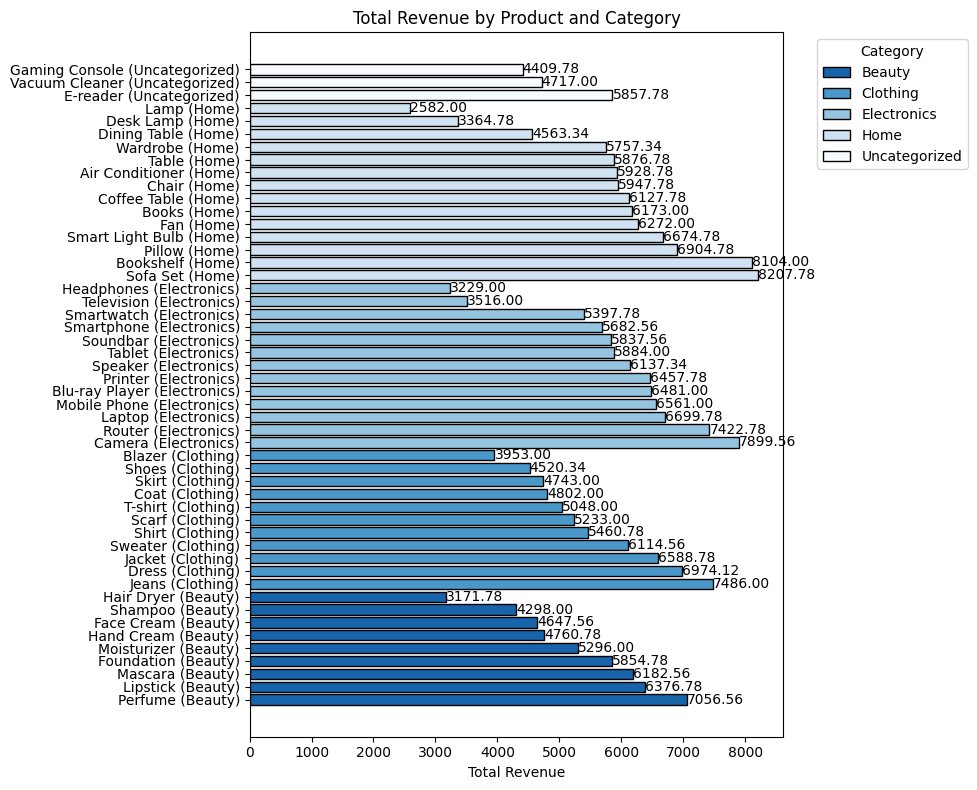

In [57]:
product_sales_df = product_sales_df.toPandas()

# Sort the DataFrame by 'Category' and then by 'Total_Revenue' within each category
product_sales_df = product_sales_df.sort_values(by=['Category', 'Total_Revenue'], ascending=[True, False])

# Add category information to product names for y-axis labels
product_sales_df['Product_Label'] = product_sales_df['Product_Name'] + ' (' + product_sales_df['Category'] + ')'

# Get unique categories for color coding
categories = product_sales_df['Category'].unique()

# Sort and add the product label (if not already done)
product_sales_df['Product_Label'] = product_sales_df['Product_Name'] + ' (' + product_sales_df['Category'] + ')'

logger.info('Total Revenue of Each Product by Category')
# Call the plot function
plot_horizontal_barh(product_sales_df, 'Category', 'Product_Label', 'Total_Revenue', 'Total Revenue by Product and Category')

# 2. Sales Volume of Each Product by Category

2024-09-09 05:29:52,182 - logger - INFO - Sales Volume of Each Product by Category


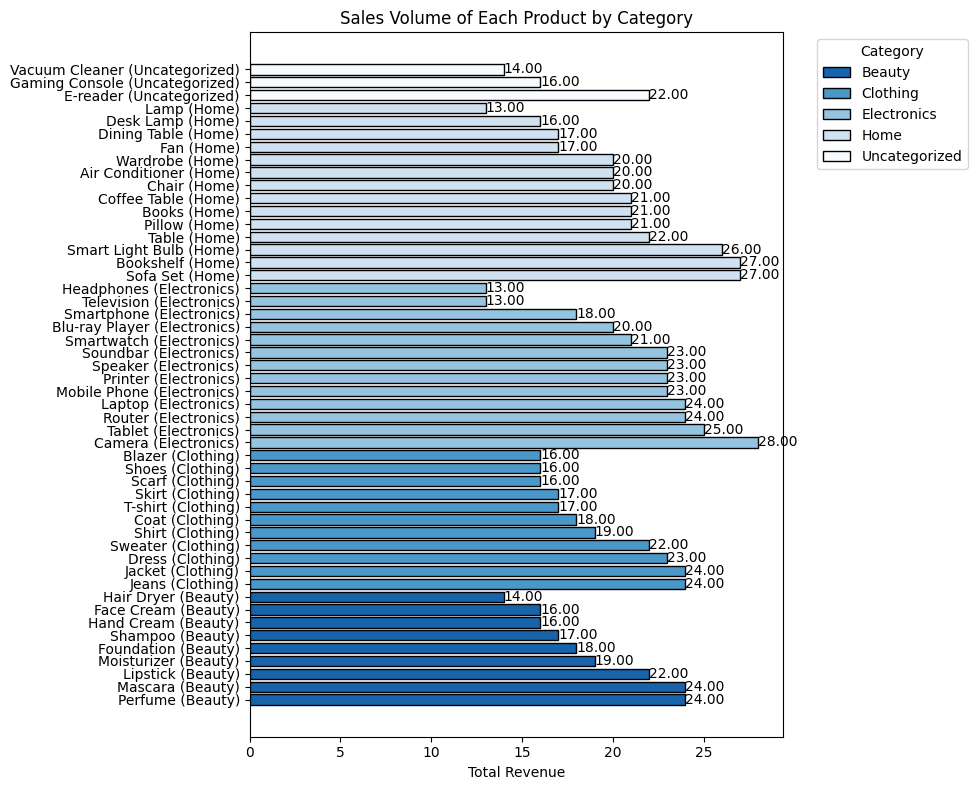

In [58]:
# product_sales_df = product_sales_df.toPandas()

# Sort the DataFrame by 'Category' and then by 'Sales_Volume' within each category
product_sales_df = product_sales_df.sort_values(by=['Category', 'Sales_Volume'], ascending=[True, False])

# Add category information to product names for y-axis labels
product_sales_df['Product_Label'] = product_sales_df['Product_Name'] + ' (' + product_sales_df['Category'] + ')'

# Get unique categories for color coding
categories = product_sales_df['Category'].unique()
# Call the reusable plot function to visualize sales volume by product and category
logger.info("Sales Volume of Each Product by Category")

plot_horizontal_barh(
    df=product_sales_df, 
    category_col='Category', 
    label_col='Product_Label', 
    value_col='Sales_Volume', 
    title='Sales Volume of Each Product by Category'
)

# 3. Total Sales Volume by Product Category

2024-09-09 05:29:53,042 - logger - INFO - Total Sales Volume by Product Category


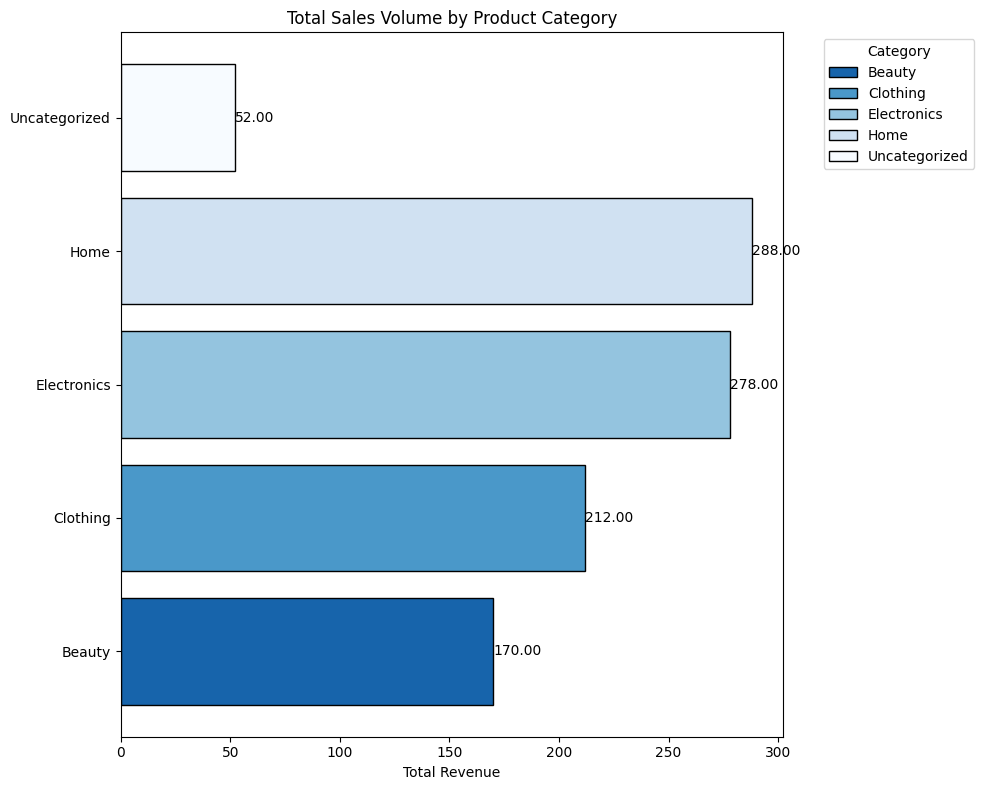

In [59]:
# Join the transactions DataFrame with the products DataFrame on Product_ID
merged_df = transactions_df.join(products_df, on='Product_ID').toPandas()
# Aggregate the number of purchases by product and category
product_purchases = merged_df.groupby(['Product_Name', 'Category']).agg({'Transaction_ID': 'count'}).reset_index()
category_purchases = merged_df.groupby(['Category']).agg({'Transaction_ID': 'count'}).reset_index()

# Rename columns for clarity
product_purchases.rename(columns={'Transaction_ID': 'Purchase_Count'}, inplace=True)
category_purchases.rename(columns={'Transaction_ID': 'Purchase_Count'}, inplace=True)

# Sort by Purchase_Count to get top items
top_products = product_purchases.sort_values(by='Purchase_Count', ascending=False)
top_categories = category_purchases.sort_values(by='Purchase_Count', ascending=False)

logger.info("Total Sales Volume by Product Category")
plot_horizontal_barh(
    df=top_categories, 
    category_col='Category', 
    label_col='Category', 
    value_col='Purchase_Count',
    title='Total Sales Volume by Product Category'
)

## 4. Top 20 Products by Total Revenue

2024-09-09 05:29:53,255 - logger - INFO - Top 20 Products by Total Revenue


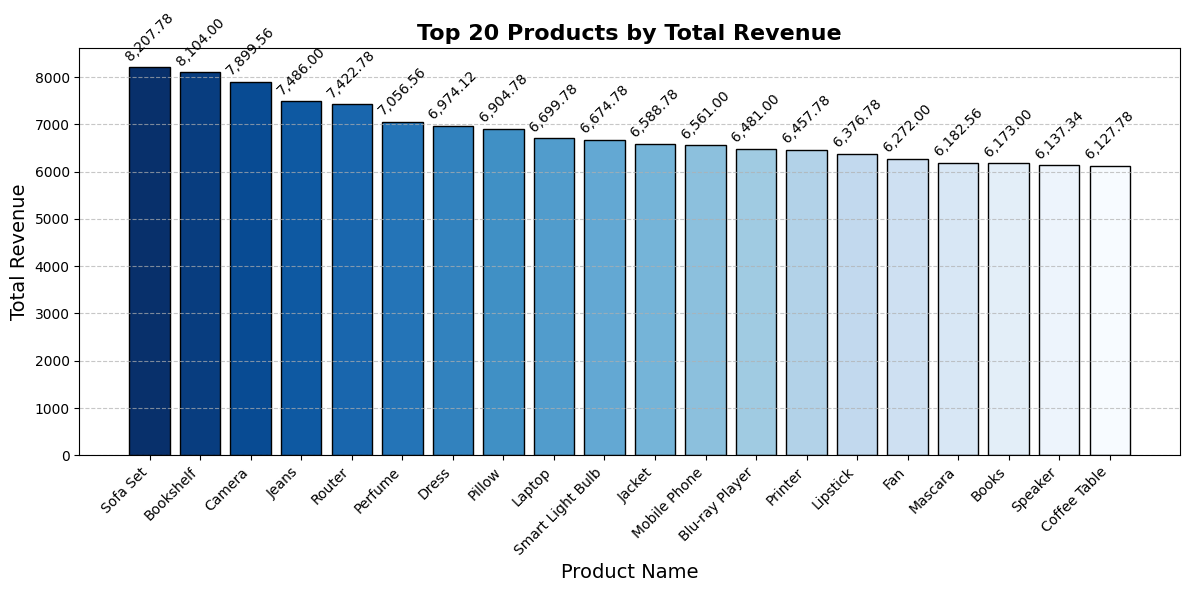

In [60]:
# Sort by Total_Revenue to get the top 10 products
top_products_revenue = product_sales_df.sort_values(by='Total_Revenue', ascending=False).head(20)
logger.info('Top 20 Products by Total Revenue')
plot_vertical_bar(
    df=top_products_revenue, 
    label_col='Product_Name', 
    value_col='Total_Revenue',
    title='Top 20 Products by Total Revenue'
)

## 5. Top 20 Products by Sales Volume

2024-09-09 05:29:53,654 - logger - INFO - Top 20 Products by Sales Volume


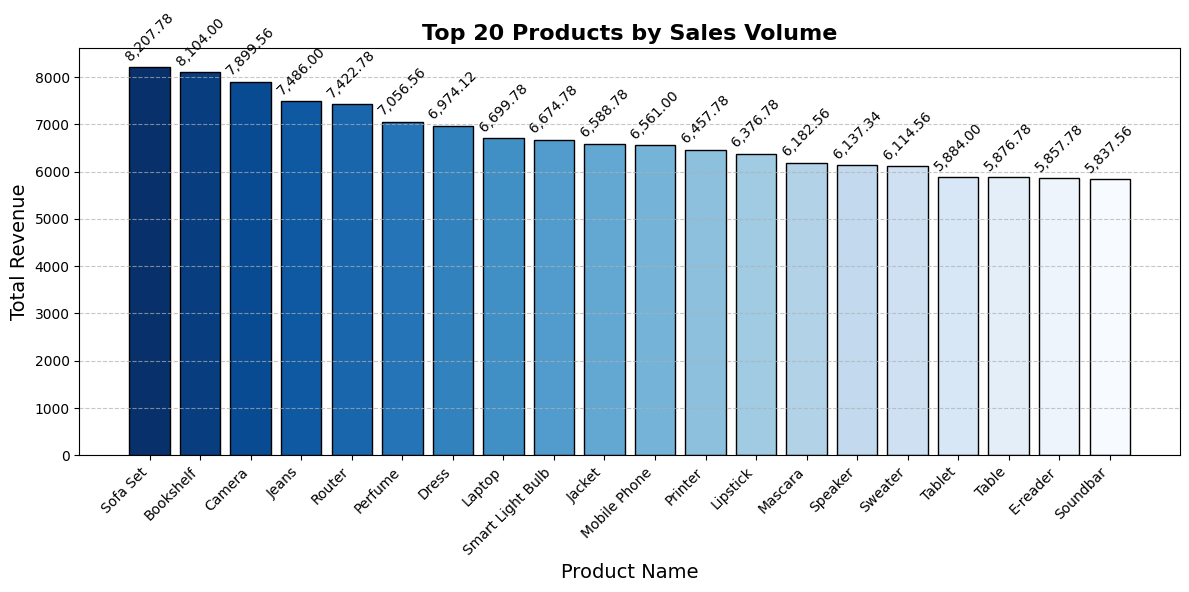

In [61]:
# Sort by Sales_Volume to get the top 10 products
top_products = product_sales_df.sort_values(by='Sales_Volume', ascending=False).head(20)
logger.info("Top 20 Products by Sales Volume")
plot_vertical_bar(
    df=top_products, 
    label_col='Product_Name', 
    value_col='Total_Revenue',
    title='Top 20 Products by Sales Volume'
)

## 6. Effect of Pricing on Sales Volume by Category

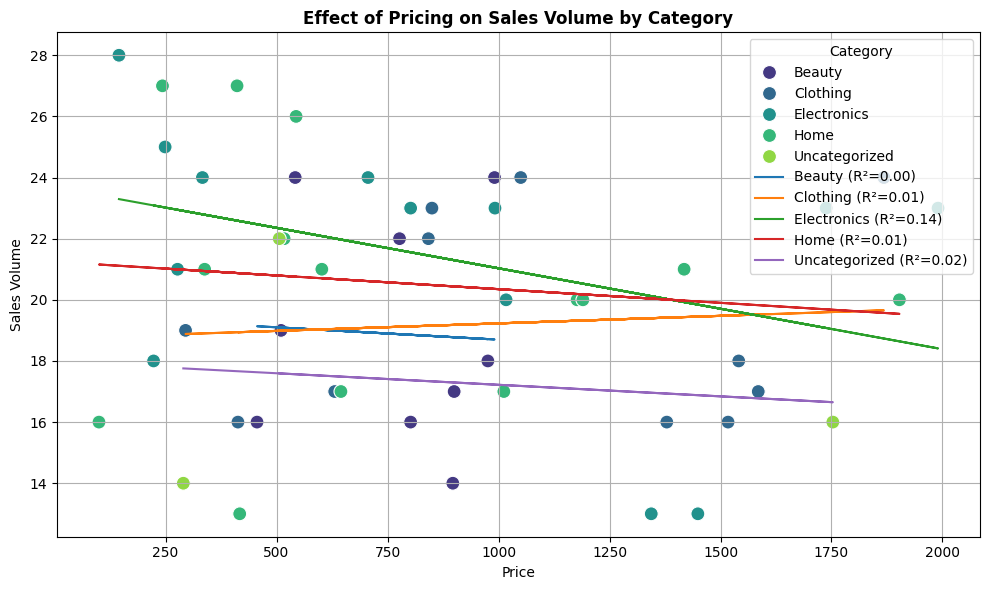

In [62]:
# Scatter plot to visualize the relationship between price and sales volume
plt.figure(figsize=(10, 6))
sns.scatterplot(data=product_sales_df, x='Price', y='Sales_Volume', hue='Category', palette='viridis', s=100)

# Fit a linear regression line to see the trend
for category in product_sales_df['Category'].unique():
    cat_data = product_sales_df[product_sales_df['Category'] == category]
    slope, intercept, r_value, p_value, std_err = linregress(cat_data['Price'], cat_data['Sales_Volume'])
    plt.plot(cat_data['Price'], intercept + slope * cat_data['Price'], label=f'{category} (R²={r_value**2:.2f})')

# Title and labels
plt.title('Effect of Pricing on Sales Volume by Category', fontweight= 'bold')
plt.xlabel('Price')
plt.ylabel('Sales Volume')
plt.legend(title='Category')
plt.grid(True)
plt.tight_layout()

plt.show()

# 7. Category Performance by Total Revenue

2024-09-09 05:29:54,629 - logger - INFO - Total Revenue Contribution by Product Category


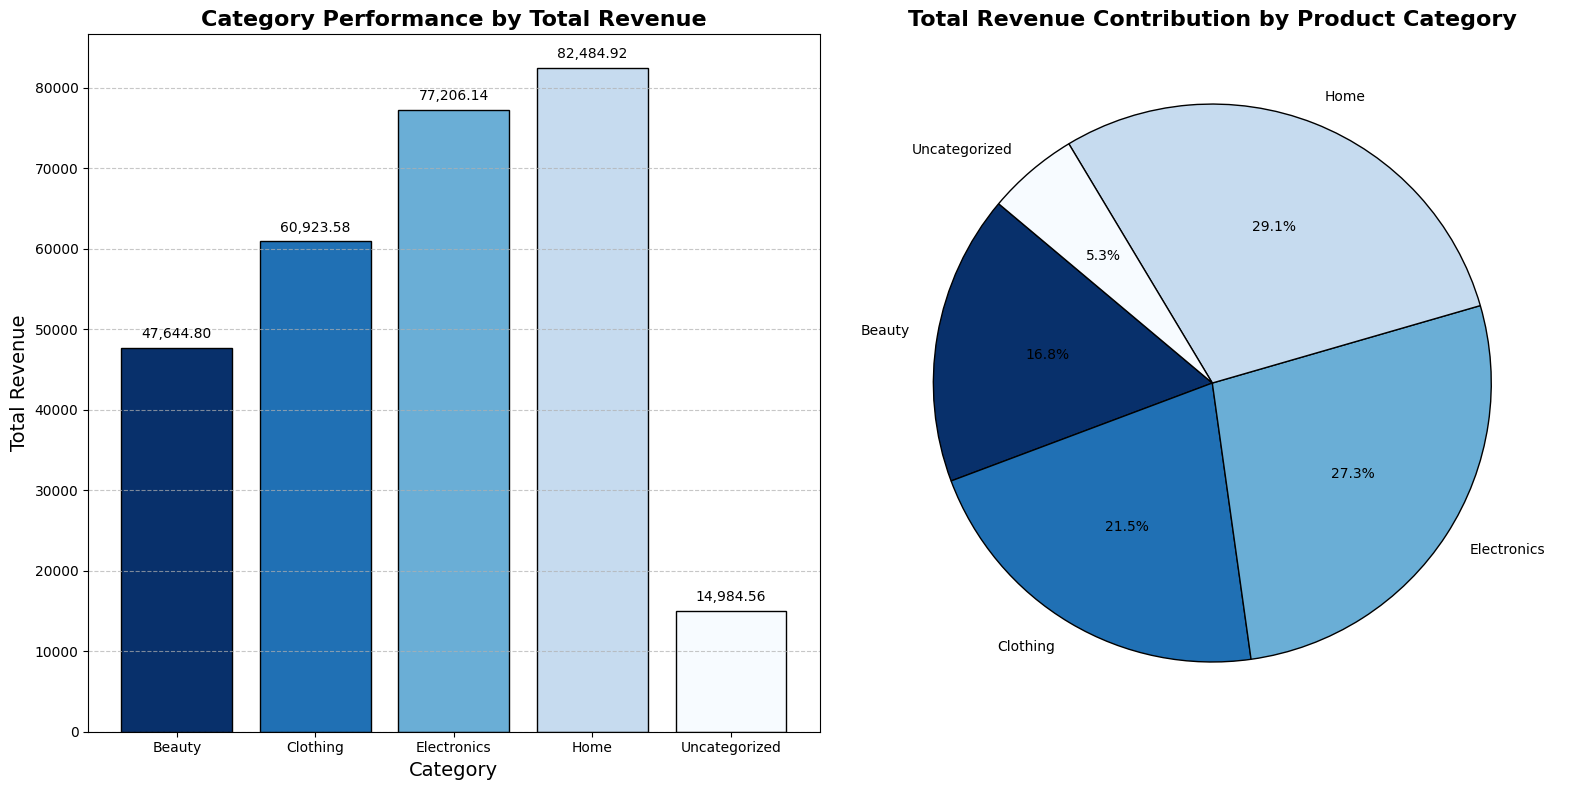

In [63]:
# Evaluate Category Performance by Total Revenue
category_performance = product_sales_df.groupby('Category').agg({
    'Total_Revenue': 'sum',
    'Sales_Volume': 'sum'
}).reset_index()

# Aggregate total spending by category
category_spending = merged_df.groupby(['Category']).agg({'Amount': 'sum'}).reset_index()

# Define a colormap for shades of blue
cmap = get_cmap('Blues')
colors = cmap(np.linspace(0, 1, len(category_performance)))[::-1]

# Set up the figure and axes for the two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Plot 1: Bar plot for Category Performance by Total Revenue
bars = ax1.bar(category_performance['Category'], category_performance['Total_Revenue'], color=colors, edgecolor='black')

# Customize the bar plot title and labels
ax1.set_title('Category Performance by Total Revenue', fontsize=16, fontweight='bold')
ax1.set_xlabel('Category', fontsize=14)
ax1.set_ylabel('Total Revenue', fontsize=14)
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars
for bar in bars:
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * max(category_performance['Total_Revenue']),
        f'{height:,.2f}',
        ha='center',
        va='bottom',
        fontsize=10
    )

# Plot 2: Pie chart for Total Revenue Contribution by Product Category
ax2.pie(
    category_spending['Amount'], 
    labels=category_spending['Category'], 
    colors=colors, 
    autopct='%1.1f%%', 
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)

# Customize the pie chart title
ax2.set_title('Total Revenue Contribution by Product Category', fontsize=16, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()
logger.info("Total Revenue Contribution by Product Category")
# Display the combined figure
plt.show()
